In [1]:
# Import libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.pipeline as spl
import sklearn.kernel_ridge as skr
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.neural_network as snn
import sklearn.metrics as sme
import sklearn.decomposition as sdc
import sklearn.cross_decomposition as skd
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
from sklearn.utils import resample
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util_arch as util

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
#     Performed poorly using Standard and MinMax scalers. Trying with LOOCV to see if predictions stabilize.
#     Does not appear to stabilize predictions with LOOCV (using StandardScaler())
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function?
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


In [5]:
results_ls = np.zeros_like(per_change)
results_lsm = np.zeros_like(per_change)

In [8]:
for j in np.arange(len(subsc)):
    Js = []
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # X_train, y_train = sku.shuffle(X_train, y_train, random_state=1)

    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,True,False,False)
    # for jj in np.arange((X0_ss0.shape[1])):
    #     with np.errstate(divide='ignore', invalid='ignore'):
    #         lr_prepost = stats.linregress(X0_ss0[:,jj],y_train)
    #     #print(lr_prepost.rvalue)
    #     if lr_prepost.rvalue>0.15:
    #         Js.append(jj)
    #         # print('Feature',str(jj),K_all_c.reshape(K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2])[1,jj],
    #         #     'in ROI',R_all_c.reshape(R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2])[1,jj],
    #         #     'has correlation',str(lr_prepost.rvalue))

    
    # Feature selection
    sel = skf.SelectKBest(skf.r_regression,k=1800)
    X0_ss = sel.fit_transform(X0_ss0,y_train)
    X_test_ss = sel.transform(X_test_ss0)#.reshape([X_test_ss0.shape[0],
#                                             X_test_ss0.shape[1]*X_test_ss0.shape[2]]))
    #X0_ss = X0_ss0[:,Js]
    #X_smogn,y_smogn = util.rad_smogn(X0_ss,y_train,np.min(y_train),np.mean(y_train),1,0,0.5,0.02)
    #cvn = len(X_smogn)-1
    # X_test_ss = X_test_ss0.reshape(X_test_ss0.shape[0],X_test_ss0.shape[1]*X_test_ss0.shape[2])
    # LASSO
    lasso = slm.LassoCV(max_iter=1e5) 
    est_ls = lasso.fit(X0_ss,y_train)
    # results_ls[j] = est_ls.predict(X_test_ss[0][Js].reshape(1,-1))
    results_ls[j] = est_ls.predict(X_test_ss)
    # # Ridge
    # ridge = slm.LarsCV(eps=1e-2,normalize=False)
    # est_rr = ridge.fit(X0_ss,y_train)
    # results_lsm[j] = est_rr.predict(X_test_ss[0][Js].reshape(1,-1))
    # print('Ridge predicts',str(results_lsm[j]),'with regularization',
    #       str(est_rr.alpha_),'for case with',str(per_change[j]))
    
    #est_lsm = #lasso.fit(X_smogn,y_smogn)
 
    print('Lasso predicts',str(results_ls[j]),'with regularization',
          str(est_ls.alpha_),'from',str(len(X_test_ss)),'features for case',str(test_id),'with actual improvement',str(per_change[j]))
    # print('Lasso+SMOGN predicts',str(results_lsm[j]),'with regularization',
    #       str(est_rr.alpha_),'for case',str(test_id),'with actual improvement',str(per_change[j]))



/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.4440631615979088 with regularization 0.00010057290028666112 from 1 features for case 67.0 with actual improvement 0.48333333333333334


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5347616595841084 with regularization 0.00010398035083221119 from 1 features for case 75.0 with actual improvement 0.967741935483871


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.4523141906240027 with regularization 0.00010352015549210435 from 1 features for case 68.0 with actual improvement 0.7454545454545455


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6640535026834621 with regularization 0.00010239140494806913 from 1 features for case 79.0 with actual improvement 0.6551724137931034


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.9077709345687601 with regularization 0.00010012715627656456 from 1 features for case 59.0 with actual improvement 0.7435897435897436


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.45216531895689527 with regularization 0.00010032265693030519 from 1 features for case 85.0 with actual improvement 0.14705882352941177


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.861997054648472 with regularization 0.00010099380640087255 from 1 features for case 63.0 with actual improvement 0.8529411764705882


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.3630353945915743 with regularization 0.00010260089557360662 from 1 features for case 66.0 with actual improvement 0.53125


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6444034529128184 with regularization 0.0001025260451772647 from 1 features for case 86.0 with actual improvement 0.5


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5716070813616922 with regularization 9.920638058990682e-05 from 1 features for case 69.0 with actual improvement 0.4857142857142857


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.4934855055238664 with regularization 0.0026074975277453043 from 1 features for case 72.0 with actual improvement 0.2608695652173913


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.7113597425993813 with regularization 0.00010067008917641466 from 1 features for case 80.0 with actual improvement 0.5227272727272727


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5627347547006347 with regularization 8.828208382989331e-05 from 1 features for case 81.0 with actual improvement 0.19444444444444445


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.741973716565333 with regularization 0.0001038158777972134 from 1 features for case 77.0 with actual improvement 0.559322033898305


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.8982458115219748 with regularization 0.00010150693844389639 from 1 features for case 64.0 with actual improvement 0.6615384615384615


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5685088073586874 with regularization 0.00010105539335944609 from 1 features for case 83.0 with actual improvement 0.8392857142857143


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5045258395153964 with regularization 9.880325060741829e-05 from 1 features for case 62.0 with actual improvement 0.46774193548387094


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5139658143323329 with regularization 0.0012201915098716853 from 1 features for case 87.0 with actual improvement 0.08571428571428572


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.7650444498273942 with regularization 0.0001007047244688841 from 1 features for case 58.0 with actual improvement 0.5172413793103449


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.536946706365763 with regularization 0.0013003405189833857 from 1 features for case 89.0 with actual improvement 0.358974358974359


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6162386524553427 with regularization 0.0008856419942946067 from 1 features for case 78.0 with actual improvement 0.825


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5404917700931025 with regularization 9.736597410991502e-05 from 1 features for case 90.0 with actual improvement 0.3023255813953488


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6532682960462495 with regularization 9.689380561401538e-05 from 1 features for case 61.0 with actual improvement 0.8461538461538461


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6762352555965397 with regularization 0.00010245117312330364 from 1 features for case 1.0 with actual improvement 0.8307692307692308


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5280889869567643 with regularization 0.00010814047718957185 from 1 features for case 2.0 with actual improvement 0.9090909090909091


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5729038376736844 with regularization 0.00010104720292181678 from 1 features for case 3.0 with actual improvement 0.5555555555555556


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.8003784846432906 with regularization 0.00010545728549157158 from 1 features for case 6.0 with actual improvement 0.9523809523809523


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5179183416906267 with regularization 0.00011334880025331258 from 1 features for case 9.0 with actual improvement 0.8888888888888888


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6830880277275733 with regularization 0.00010189572371709371 from 1 features for case 10.0 with actual improvement 0.5925925925925926


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6263309117182551 with regularization 0.00010025468917660574 from 1 features for case 11.0 with actual improvement 0.7368421052631579


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6529900927786171 with regularization 0.00010876022726640774 from 1 features for case 12.0 with actual improvement 0.5


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.7128098708771106 with regularization 0.000101837922520079 from 1 features for case 13.0 with actual improvement 0.7037037037037037


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6606488147926581 with regularization 0.00010118352400533164 from 1 features for case 15.0 with actual improvement 0.6865671641791045


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.775183298033971 with regularization 0.000104429856206876 from 1 features for case 16.0 with actual improvement 0.8787878787878788


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5983541592875243 with regularization 0.00010216200614946736 from 1 features for case 20.0 with actual improvement 0.6666666666666666


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.7288421480130323 with regularization 0.000101150930256801 from 1 features for case 25.0 with actual improvement 0.7


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.727204032412387 with regularization 9.504756481053432e-05 from 1 features for case 26.0 with actual improvement 0.8831168831168831


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.49951145489653304 with regularization 0.00011236738587136468 from 1 features for case 27.0 with actual improvement 0.7441860465116279


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.6307911701486908 with regularization 9.971251203278817e-05 from 1 features for case 29.0 with actual improvement 0.8035714285714286


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5895553749589693 with regularization 0.00010166595357576178 from 1 features for case 32.0 with actual improvement 0.6666666666666666


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.703970287948055 with regularization 0.00010121101094380183 from 1 features for case 34.0 with actual improvement 0.691358024691358


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.4613935568198119 with regularization 0.00010178700602862395 from 1 features for case 41.0 with actual improvement 0.42857142857142855


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.21352955930673206 with regularization 0.00010206461952841021 from 1 features for case 44.0 with actual improvement 0.1875


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.7311830214720312 with regularization 0.00010216640145454795 from 1 features for case 45.0 with actual improvement 0.9393939393939394


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.5667605288586406 with regularization 0.0001024523782608328 from 1 features for case 46.0 with actual improvement 0.5555555555555556


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.530619269153142 with regularization 0.00010123086496564129 from 1 features for case 52.0 with actual improvement 0.6724137931034483


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Lasso predicts 0.7178694675023188 with regularization 9.820573575599287e-05 from 1 features for case 54.0 with actual improvement 0.873015873015873


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)


(0.0, 2.0)

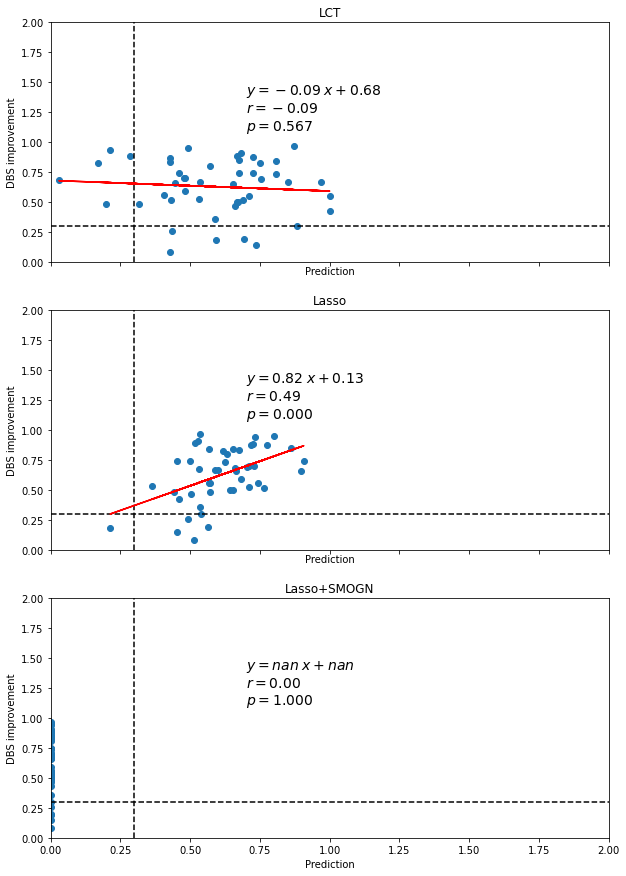

In [9]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               results_lsm)),
                               per_change,
                               ['LCT',
                                'Lasso',
                                'Lasso+SMOGN'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])